Training Progress:   0%|          | 1/300 [00:21<1:47:33, 21.58s/it]

Epoch 0, Loss: 30680.277391


Training Progress:  17%|█▋        | 51/300 [17:24<1:24:24, 20.34s/it]

Epoch 50, Loss: 24901.004964


Training Progress:  34%|███▎      | 101/300 [34:34<1:08:54, 20.77s/it]

Epoch 100, Loss: 16368.627313


Training Progress:  50%|█████     | 151/300 [51:46<52:30, 21.14s/it]  

Epoch 150, Loss: 11399.115944


Training Progress:  67%|██████▋   | 201/300 [1:09:24<44:24, 26.92s/it]

Epoch 200, Loss: 8440.790427


Training Progress:  84%|████████▎ | 251/300 [1:26:39<16:36, 20.33s/it]

Epoch 250, Loss: 5802.760646


Training Progress: 100%|██████████| 300/300 [1:43:18<00:00, 20.66s/it]


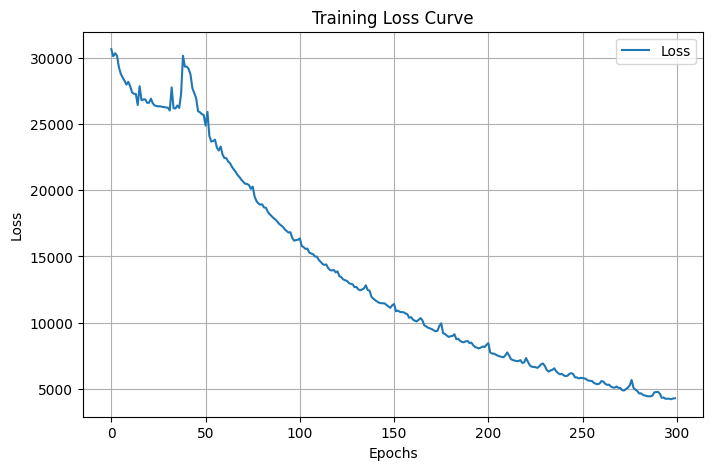

In [17]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

dataset_path = '/kaggle/input/ae646-gp1-data/0012.csv'
df = pd.read_csv(dataset_path)
x = df["Points:0"].values  # X-coordinates
y = df["Points:1"].values  # Y-coordinates
u = df["U:0"].values  # X-velocity
v = df["U:1"].values  # Y-velocity
p = df["p"].values  # Pressure

X = np.column_stack([x, y]).astype(np.float32)  
Y = np.column_stack([u, v, p]).astype(np.float32)  

batch_size = 5096
dataset = tf.data.Dataset.from_tensor_slices((X, Y))
dataset = dataset.shuffle(buffer_size=10000).batch(batch_size)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='tanh', input_shape=(2,)),  # Input (x, y)
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(3)  # Output: (u, v, p)
])

# Loss Function with Continuity Equation
def loss_function(model, X, Y, lambda_physics=1.0):
    X = tf.convert_to_tensor(X, dtype=tf.float32)
    Y = tf.convert_to_tensor(Y, dtype=tf.float32)
    
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(X)
        Y_pred = model(X)  
        
        # Data Loss (MSE)
        data_loss = tf.reduce_mean(tf.square(Y_pred - Y))
        
        u_pred = Y_pred[:, 0]  # u
        v_pred = Y_pred[:, 1]  # v
        
        with tf.GradientTape() as g_tape:
            g_tape.watch(X)
            u_pred = model(X)[:, 0]  
        grad_u = g_tape.gradient(u_pred, X)  
        du_dx = grad_u[:, 0]  
        
        with tf.GradientTape() as g_tape:
            g_tape.watch(X)
            v_pred = model(X)[:, 1]  
        grad_v = g_tape.gradient(v_pred, X)  
        dv_dy = grad_v[:, 1]  
        
        # Physics Loss: Continuity Equation (∂u/∂x + ∂v/∂y = 0)
        continuity_eq = du_dx + dv_dy
        physics_loss = tf.reduce_mean(tf.square(continuity_eq))
    
    del tape
    
    return data_loss + lambda_physics * physics_loss

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
n_epochs = 300
loss_history = []

for epoch in tqdm(range(n_epochs), desc="Training Progress"):
    epoch_loss = 0.0
    for batch_X, batch_Y in dataset:
        with tf.GradientTape() as tape:
            loss = loss_function(model, batch_X, batch_Y, lambda_physics=1.0)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        epoch_loss += loss.numpy()
    
    avg_loss = epoch_loss / len(dataset)
    loss_history.append(avg_loss)
    
    if epoch % 50 == 0:  
        print(f"Epoch {epoch}, Loss: {avg_loss:.6f}")

model.save("pinn_velocity_pressure_model.h5")

plt.figure(figsize=(8, 5))
plt.plot(loss_history, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
import gc
gc.collect()

3723